# 03 - Forecast Evaluation
Walk-forward out-of-sample variance forecasts and metrics (MSE variance, MAE volatility, QLIKE).

In [1]:
import sys
from pathlib import Path

# Ensure repository root is on the path when running from notebooks/
ROOT = Path.cwd()
if not (ROOT / 'src').exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))
print(f"Using project root: {ROOT}")

Using project root: /Users/mahdihoumani/Documents/Quant/VolatilityModellingAndOptionPricing/volatility-options-quant


In [2]:
import matplotlib.pyplot as plt

import pandas as pd

from src.data_loader import download_price_data
from src.returns import log_returns, TRADING_DAYS
from src.vol_models.historical import rolling_vol, forecast_next_variance as hist_forecast
from src.vol_models.ewma import ewma_vol, forecast_next_variance as ewma_forecast
from src.vol_models.garch import fit_garch11, forecast_next_variance as garch_forecast_var
from src.evaluation import walk_forward_forecast, evaluate_forecasts, windowed_realized_volatility

# Parameters
TICKER = 'SPY'
START = '2018-01-01'
END = None
TRAIN_START_SIZE = 500  # initial training size in days
ROLL_WINDOW = 21
EWMA_LAMBDA = 0.94

prices = download_price_data(TICKER, START, END)
returns = log_returns(prices['adj_close']).dropna()
returns.head()

Date
2018-01-03    0.006305
2018-01-04    0.004206
2018-01-05    0.006642
2018-01-08    0.001827
2018-01-09    0.002261
Name: log_return, dtype: float64

In [3]:
# Define model forecast functions returning variance
def hist_model(train: pd.Series) -> float:
    return hist_forecast(train, window=ROLL_WINDOW)

def ewma_model(train: pd.Series) -> float:
    return ewma_forecast(train, lam=EWMA_LAMBDA)

def garch_model(train: pd.Series) -> float:
    # Fit GARCH(1,1); may be slow.
    res = fit_garch11(train, annualize=False)
    fitted = res['result']
    return garch_forecast_var(fitted)

model_funcs = {
    'hist': hist_model,
    'ewma': ewma_model,
}
try:
    import arch  # noqa: F401
    model_funcs['garch11'] = garch_model
except ImportError:
    print('arch not installed; skipping GARCH model')

forecast_var = walk_forward_forecast(returns, model_funcs, start=TRAIN_START_SIZE, expanding=True)
forecast_var.head()

,hist,ewma,garch11
2019-12-30,0.000022,0.000022,0.000029
2019-12-31,0.000023,0.000021,0.000033
2020-01-02,0.000022,0.000021,0.000031
2020-01-03,0.000020,0.000021,0.000047
2020-01-06,0.000021,0.000024,0.000052


In [4]:
# Evaluate forecasts
metrics = evaluate_forecasts(
    forecast_var,
    returns,
    realized_windows=[5, 21],
    annualize_pred=True,
    periods_per_year=TRADING_DAYS,
)
metrics

mse_var   mae_vol     qlike
model   window                              
hist    5       0.009359  0.052850 -2.713700
        21      0.000178  0.007565 -2.767174
ewma    5       0.008596  0.056341 -2.683947
        21      0.000927  0.021133 -2.732824
garch11 5       0.001597  0.032931 -2.838724
        21      0.004505  0.033791 -2.679181

Using windowed realized volatility (e.g., 5- and 21-day RV) smooths noisy single-day squared returns, making forecast comparisons more interpretable.

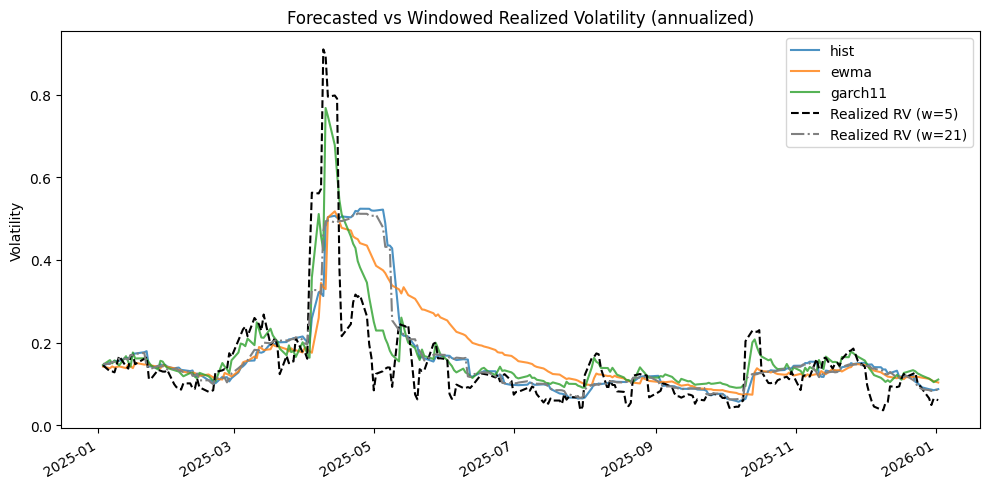

In [5]:
# Plot forecasted volatility vs realized (windowed RV)
subset = forecast_var.index[-250:]  # last ~1 year
realized_rv = windowed_realized_volatility(returns, windows=[5, 21])
realized_sub = realized_rv.loc[subset]
forecast_vol_ann = (forecast_var.loc[subset] * TRADING_DAYS) ** 0.5
ax = forecast_vol_ann.plot(figsize=(10, 5), alpha=0.8)
realized_sub['rv_5'].plot(ax=ax, color='k', linestyle='--', label='Realized RV (w=5)')
realized_sub['rv_21'].plot(ax=ax, color='gray', linestyle='-.', label='Realized RV (w=21)')
ax.set_title('Forecasted vs Windowed Realized Volatility (annualized)')
ax.set_ylabel('Volatility')
ax.legend()
plt.tight_layout()
plt.show()
